In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f'{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPU')
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU found, training will default to CPU.")

1 Physical GPUs, 1 Logical GPU


In [ ]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import shutil
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
#Check number of images in each folder
path = "/content/drive/MyDrive/KaggleData/Image_Dataset/"
dir_list = [os.path.join(path,i) for i in os.listdir(path) if os.path.isdir(os.path.join(path,i))]
size_dict = {}
for i,value in enumerate(dir_list):
    size_dict[os.listdir(path)[i]] = len(os.listdir(value))
size_dict

{'Benign': 2480, 'Malignant': 5429}

In [ ]:
# Save the Dataset with Pickle

import pickle

# Specify the filename you want to save the dataset as
dataset_filename = '/content/drive/MyDrive/KaggleData/full_data.pkl'

# Open a file in binary-write mode and dump the full_data list into it
with open(dataset_filename, 'wb') as dataset_file:
    pickle.dump(full_data, dataset_file)

print(f"Dataset successfully saved to {dataset_filename}")


Dataset successfully saved to /content/drive/MyDrive/KaggleData/Image_Dataset/full_data.pkl


In [ ]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Path to the pickle file
dataset_filename = '/content/drive/MyDrive/KaggleData/full_data.pkl'

# Load the dataset
with open(dataset_filename, 'rb') as dataset_file:
    full_data = pickle.load(dataset_file)

print("Dataset successfully loaded.")
print(f"Total number of samples in the dataset: {len(full_data)}")

Dataset successfully loaded.
Total number of samples in the dataset: 7909


In [ ]:
IMG_SIZE = 224

# Prepare your data and labels
full_images = np.array([item[0] for item in full_data])  # Image data
full_labels = np.array([item[1] for item in full_data])  # Labels

# Reshape image data for oversampling
full_images_reshaped = full_images.reshape(-1, IMG_SIZE * IMG_SIZE * 3)

# Initial train/test split with stratification
training_data_reshaped, test_data_reshaped, training_labels, test_labels = train_test_split(
    full_images_reshaped, full_labels, test_size=0.1, random_state=30, stratify=full_labels)

# Apply RandomOverSampler on the reshaped training data
ros = RandomOverSampler(random_state=42)
training_data_resampled, training_labels_resampled = ros.fit_resample(training_data_reshaped, training_labels)

# Reshape the data back to its original shape after oversampling
training_dataset = training_data_resampled.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

# Extracting validation dataset from the training data (with stratification)
training_dataset, val_dataset, training_labels, val_labels = train_test_split(
    training_dataset, training_labels_resampled, test_size=0.1, random_state=30, stratify=training_labels_resampled)

# Reshape test data back to its original shape
test_dataset = test_data_reshaped.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(f"Training dataset size: {len(training_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 8794
Validation dataset size: 978
Test dataset size: 791


In [ ]:
# # Normalize each dataset independently
training_dataset = np.array(training_dataset, dtype="float32") / 255.0
val_dataset = np.array(val_dataset, dtype="float32") / 255.0
test_dataset = np.array(test_dataset, dtype="float32") / 255.0


In [ ]:
import pandas as pd

# Check the data distribution among the classes for training, validation, and test sets
print("Training labels distribution:\n", pd.Series(training_labels).value_counts())
print("Validation labels distribution:\n", pd.Series(val_labels).value_counts())
print("Test labels distribution:\n", pd.Series(test_labels).value_counts())



Training labels distribution:
 1    4397
0    4397
dtype: int64
Validation labels distribution:
 0    489
1    489
dtype: int64
Test labels distribution:
 1    543
0    248
dtype: int64


# Model Training

In [ ]:
#Importing libraries needed for the modeling and training
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, Callback , ModelCheckpoint
from tensorflow.keras.metrics import Accuracy,binary_crossentropy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
#Setting the batch size for the cnn model
bs = 64

In [ ]:
#Defining Image Data Generator for image augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    fill_mode='nearest',
    zoom_range=0.2)

# Custom CNN Model 1

In [ ]:
#Defining the base model
cancer_model = Sequential()

#First Layer
cancer_model.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (224,224,3), activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))

#Second Layer
cancer_model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same',activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))

#Third Layer
cancer_model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))
cancer_model.add(Dropout(0.4))

#Fourth Layer
cancer_model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))
cancer_model.add(Dropout(0.2))

#Fifth Layer
cancer_model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))

#Flattening the layers
cancer_model.add(Flatten())

#Adding the dense layer
cancer_model.add(Dense(256, activation = 'relu'))
cancer_model.add(Dense(128, activation = 'relu'))
cancer_model.add(Dense(1, activation = 'sigmoid'))

cancer_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 55, 55, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 27, 27, 128)       0

In [ ]:
#Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=20*50,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [ ]:
#Compiling the model
cancer_model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
# checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)

In [ ]:
# Assuming training_dataset and val_dataset are your prepared and possibly normalized datasets
training_images = training_dataset
val_images = val_dataset


#Fitted the model on the training and and validation dataset using the image augmentor for 100 epochs
history = cancer_model.fit(datagen.flow(training_images, training_labels, batch_size = bs),
                                     validation_data=datagen.flow(val_images, val_labels),
                                     epochs=50,
                                     callbacks=[rlrp],
                                     verbose = 1)

Epoch 1/50
138/138 [==============================] - 102s 666ms/step - loss: 0.6085 - accuracy: 0.6636 - val_loss: 0.5512 - val_accuracy: 0.7607 - lr: 8.7951e-04
Epoch 2/50
138/138 [==============================] - 89s 647ms/step - loss: 0.4595 - accuracy: 0.8109 - val_loss: 0.4734 - val_accuracy: 0.7863 - lr: 7.8431e-04
Epoch 3/50
138/138 [==============================] - 91s 657ms/step - loss: 0.4425 - accuracy: 0.8160 - val_loss: 0.4463 - val_accuracy: 0.7955 - lr: 7.0771e-04
Epoch 4/50
138/138 [==============================] - 91s 659ms/step - loss: 0.4259 - accuracy: 0.8192 - val_loss: 0.4470 - val_accuracy: 0.8170 - lr: 6.4475e-04
Epoch 5/50
138/138 [==============================] - 91s 658ms/step - loss: 0.3863 - accuracy: 0.8364 - val_loss: 0.4099 - val_accuracy: 0.8282 - lr: 5.9207e-04
Epoch 6/50
138/138 [==============================] - 91s 657ms/step - loss: 0.3674 - accuracy: 0.8417 - val_loss: 0.3653 - val_accuracy: 0.8344 - lr: 5.4735e-04
Epoch 7/50
138/138 [=======

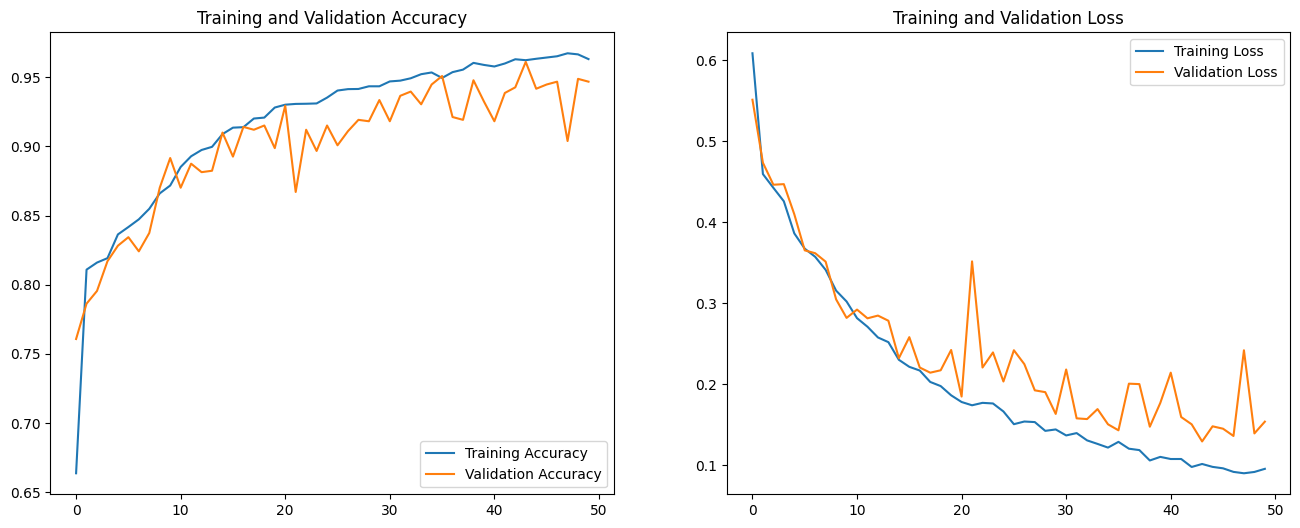

In [ ]:
#Plotting the model results

#Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Getting the losses
loss = history.history['loss']
val_loss = history.history['val_loss']

#No of epochs it trained
epochs_range = history.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Performance Evaluation of custom CNN model 1

In [ ]:
import numpy as np

y_pred = cancer_model.predict(test_dataset)


# y_pred = cancer_model.predict(test_images)

25/25 [==============================] - 1s 46ms/step


In [ ]:
print(y_pred)

[[1.00000000e+00]
 [1.00000000e+00]
 [9.72881794e-01]
 [9.99225974e-01]
 [4.74998902e-04]
 [2.71202959e-02]
 [1.93512142e-02]
 [9.96278942e-01]
 [9.99904990e-01]
 [3.13024163e-01]
 [1.00000000e+00]
 [1.00000000e+00]
 [9.99644279e-01]
 [1.00000000e+00]
 [9.98961568e-01]
 [9.99644756e-01]
 [1.60234630e-01]
 [6.36064038e-02]
 [3.06491673e-01]
 [1.83706731e-02]
 [9.99966621e-01]
 [9.99999881e-01]
 [2.32313309e-04]
 [9.98659253e-01]
 [2.49637868e-02]
 [2.50986088e-02]
 [9.99786675e-01]
 [3.68391164e-04]
 [8.06934724e-04]
 [9.99487162e-01]
 [2.95587983e-02]
 [9.62271333e-01]
 [9.99992490e-01]
 [9.99999285e-01]
 [1.23851132e-04]
 [1.51149809e-01]
 [9.99968171e-01]
 [9.95923042e-01]
 [9.99986768e-01]
 [9.97117400e-01]
 [9.99992490e-01]
 [1.00000000e+00]
 [9.94306862e-01]
 [9.91168499e-01]
 [9.99687552e-01]
 [7.98931271e-02]
 [5.48301302e-02]
 [3.31038609e-02]
 [1.98045343e-01]
 [1.00000000e+00]
 [3.39577794e-02]
 [9.99999166e-01]
 [1.23392873e-01]
 [9.37841117e-01]
 [5.92267979e-03]
 [9.994266

In [ ]:
#Round up model prediction to 0 and 1 and convert result to an array
rounded = [float(np.round(x)) for x in y_pred]
rounded_predictions = np.asarray(rounded).astype(int)
print(rounded_predictions)

[1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0 0 1 0 1 1 1 0 0 1
 1 1 1 1 1 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 0 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 0 1 0 1
 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0
 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 0 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 0 1 1 1 0 0 1 0 1 1 0 0 1 1
 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1
 1 1 1 0 0 1 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 1 1 1 1 0 0 1
 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 0 0 1
 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 1 0 1 1 1
 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0
 0 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1
 0 1 1 1 0 0 1 1 1 0 1 1 

<ipython-input-64-eb069268529b>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rounded = [float(np.round(x)) for x in y_pred]


In [ ]:
#Round up model prediction to 0 and 1 and convert result to an array
rounded = [float(np.round(x)) for x in y_pred]
rounded_predictions = np.asarray(rounded).astype(int)
print(rounded_predictions)

[1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0 0 1 0 1 1 1 0 0 1
 1 1 1 1 1 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 0 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 0 1 0 1
 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0
 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 0 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 0 1 1 1 0 0 1 0 1 1 0 0 1 1
 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1
 1 1 1 0 0 1 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 1 1 1 1 0 0 1
 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 0 0 1
 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 1 0 1 1 1
 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0
 0 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1
 0 1 1 1 0 0 1 1 1 0 1 1 

<ipython-input-65-eb069268529b>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rounded = [float(np.round(x)) for x in y_pred]


In [ ]:
#Classification report
print(classification_report(test_labels, rounded_predictions))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       248
           1       0.95      0.97      0.96       543

    accuracy                           0.95       791
   macro avg       0.94      0.93      0.94       791
weighted avg       0.95      0.95      0.95       791



[[222  26]
 [ 15 528]]


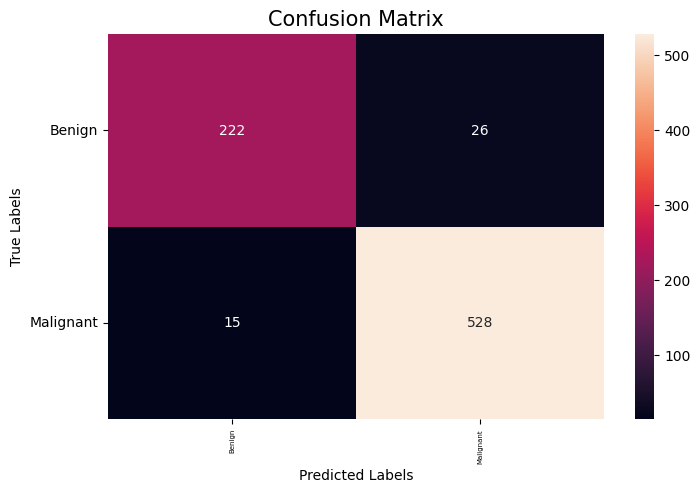

In [ ]:
#Confusion matrix
cm = confusion_matrix(test_labels, rounded_predictions)
print(cm)

import seaborn as sns

#Setting the labels
labels = ['Benign', 'Malignant']

#Plot the Confusion matrix graph
fig= plt.figure(figsize=(8, 5))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g')
ax.set_xlabel('Predicted Labels', fontsize=10)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(labels, fontsize = 5)
ax.xaxis.tick_bottom()

ax.set_ylabel('True Labels', fontsize=10)
ax.yaxis.set_ticklabels(labels, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=15)

plt.savefig('ConMat24.png')
plt.show()

In [ ]:
#Accuracy
accuracy = accuracy_score(test_labels, rounded_predictions)
print('Accuracy: %f' % accuracy)

Accuracy: 0.948167


In [ ]:
#Precision
precision = precision_score(test_labels, rounded_predictions)
print('Precision: %f' % precision)

Precision: 0.953069


In [ ]:
# Recall
recall = recall_score(test_labels, rounded_predictions, pos_label=1)
print('Recall: %f' % recall)

Recall: 0.972376


In [ ]:
#Specificity
specificity = recall_score(test_labels, rounded_predictions, pos_label=0)
print('Specificity: %f' % specificity)

Specificity: 0.895161


In [ ]:
#F1-score
F1_score = f1_score(test_labels, rounded_predictions)
print('F1_score: %f' % F1_score)

F1_score: 0.962625


# ROC CURVE

In [ ]:
print("test_labels shape:", test_labels.shape)
print("y_pred shape:", y_pred.shape)

test_labels shape: (791,)
y_pred shape: (791, 1)


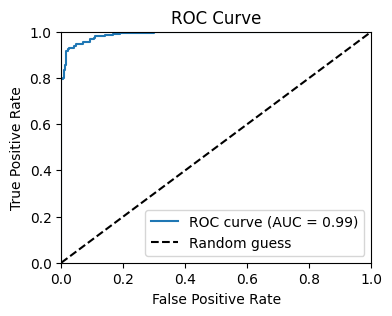

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Compute AUC score
roc_auc = roc_auc_score(test_labels, y_pred)
fpr, tpr, thresholds = roc_curve(test_labels, y_pred[:, 0])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

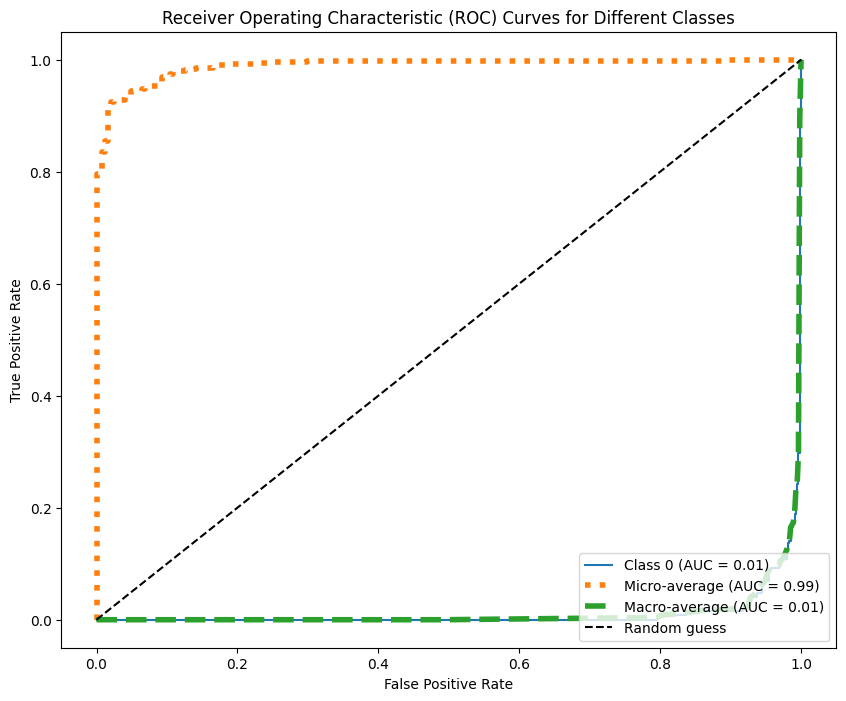

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_pred has probabilities for each class
n_classes = y_pred.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(test_labels, y_pred.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot individual class ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', linewidth=4)

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle='--', linewidth=4)

# Plot random guessing line
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Different Classes')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# !pip install accelerate

In [ ]:
# # This will restart the kernel and re-run the code from the beginning.
# %sx

[]